# BrainIAK setup

Utilizing the tutorial codebase from [BrainIAK](https://brainiak.org/tutorials/).

In [2]:
!pip install deepdish ipython matplotlib nilearn notebook pandas seaborn watchdog
!pip install pip\<10
!pip install -U git+https://github.com/brainiak/brainiak
!git clone https://github.com/brainiak/brainiak-tutorials.git
!cd brainiak-tutorials/tutorials/; cp -r 07-searchlight 09-fcma 13-real-time utils.py setup_environment.sh /content/
!mkdir /root/brainiak_datasets

  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 9.6MB 119kB/s 
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 133kB 8.1MB/s 
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 1.6MB 796kB/s 
  Using cached https://files.pythonhosted.org/packages/9d/60/54aa4ec55ae7cacb8d7e3d18af2e0b55efb55852b3e0ef482113530d3929/nibabel-5.1.0-py3-none-any.whl
  Running setup.py bdist_wheel for watchdog ... done
  Stored in directory: /root/.cache/pip/wheels/4f/20/5f/4ed60fcf90a6e294d10bf102f77ce12b3e16c74bbb9ee906ad
Successfully built watchdog
/usr/local/lib/python3.9/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py instal

In [3]:
!cd /root/brainiak_datasets; wget -q --show-progress --no-check-certificate -r 'https://drive.google.com/uc?export=download&confirm=Yqoe&id=14m-YY-N3mCjCdHGkeVlTS4uA7WJzbQS0' -O 'NinetySix.zip'
!cd /root/brainiak_datasets/; unzip NinetySix.zip

NinetySix.zip       100%[===================>] 146.49M   133MB/s    in 1.1s    
Archive:  NinetySix.zip
   creating: NinetySix/
   creating: NinetySix/Stimuli/
  inflating: NinetySix/Stimuli/RDM_hIT_fig1.txt  
  inflating: NinetySix/Stimuli/stimulus54.tif  
  inflating: NinetySix/Stimuli/RDM_mIT_fig1.txt  
  inflating: NinetySix/Stimuli/stimulus53.tif  
  inflating: NinetySix/Stimuli/stimulus1.tif  
  inflating: NinetySix/Stimuli/stimulus55.tif  
  inflating: NinetySix/Stimuli/stimulus10.tif  
  inflating: NinetySix/Stimuli/stimulus56.tif  
  inflating: NinetySix/Stimuli/stimulus11.tif  
  inflating: NinetySix/Stimuli/stimulus57.tif  
  inflating: NinetySix/Stimuli/stimulus12.tif  
  inflating: NinetySix/Stimuli/stimulus63.tif  
  inflating: NinetySix/Stimuli/stimulus13.tif  
  inflating: NinetySix/Stimuli/stimulus64.tif  
  inflating: NinetySix/Stimuli/stimulus14.tif  
  inflating: NinetySix/Stimuli/stimulus65.tif  
  inflating: NinetySix/Stimuli/stimulus15.tif  
  inflating: NinetySi

In [4]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
from sklearn.manifold import MDS
import scipy.spatial.distance as sp_distance

import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

Autosaving every 5 seconds


Four human subjects: BE, KO, SN, TI

Four ROIs from IT cortext: lFFA, rFFA, lPPA, rPPA

fMRI data for these participants was stored as a matlab file. Helper functions developed by BrainIAK help us make the files compatible with Python.

- The ROI names are listed in `roinames`
- The category label indices for each condition are listed in `labels`.  
- The names of the categories are listed in `categories`. 
- The data for each ROI, in the order of roinames, is stored in `roi_data`. 
- The images are stored as numpy arrays in `images`. Out of the 96 images, there are only 92 which we have labels for.


Each row of `roi_data` represents a stimulus (as defined by labels) and each column represents a voxel (there are different number of voxels in different ROIs). The data have been preprocessed and each entry is stored in terms of t-values (the test statistic). No time information and no baseline signal to be used as reference.

Our six image categories are:
1. Artificial inanimate
2. Human body part
3. Human face
4. Natural inanimate
5. Nonhuman body part
6. Nonhuman face

IT brain regions:
- lFFA: 34 voxels
- rFFA: 70 voxels
- lPPA: 348 voxels
- rPPA: 273 voxels

In [5]:
SUBJECTS = ['BE', 'KO', 'SN', 'TI']
N_ROIS = 4
N_IMAGES = 92
N_TOT_IMAGES = 96

# 1: Generate baseline image order.

In order to compare RDMs, we need to ensure that each cell in the matrix is responsive to the same stimuli. This is not straightforward, given that four of the images presented do not have labels, and the images were presented to each individual in a different order.

In order to do so, I'm going to designate a specific order for the images along both axes that reflects some of the underlying similarities/differences in the dataset. The images will be sorted by category, going 3-2-6-5-4-1. I will sort the images presented to subject BE by this category, and rearrange all other subject's data to match this ordering.

In [6]:
# import helper functions
from utils import load_data_for_a_subj, digitize_rdm, ns_data_dir

/content/utils.py:193: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if mask_name is '':
/content/utils.py:203: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if mask_name is not '':
/content/utils.py:237: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if mask_name is '':
/usr/local/lib/python3.9/dist-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [7]:
# load the data for one subject
subj_initials = 'BE'
data_pack = load_data_for_a_subj(subj_initials)
images, roi_data, roi_names, n_rois, categories, n_categories, labels, label_dict = data_pack
n_stimuli = len(images)

<function matplotlib.pyplot.savefig(*args, **kwargs)>

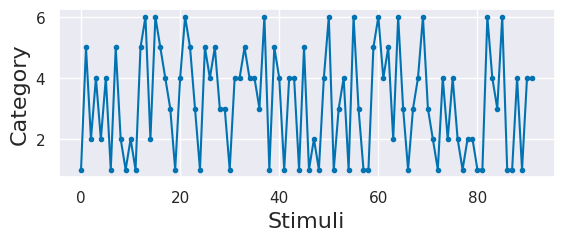

In [8]:
plt.figure()

# Label plot
plt.subplot(2,1,2)
plt.plot(labels,'.-')
plt.xlabel('Stimuli', fontsize=16)
plt.ylabel('Category', fontsize=16)
plt.savefig

Here we can see that the stimuli was originally delivered in a random order.

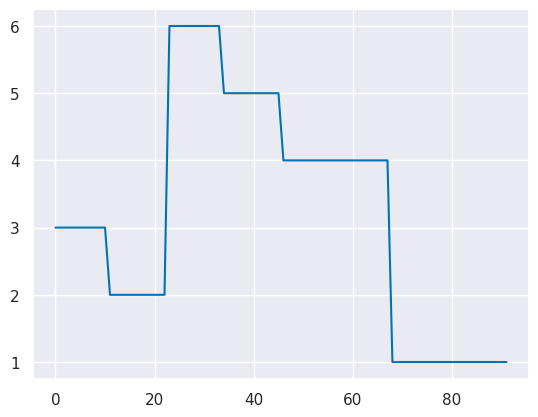

In [9]:
sort_ids = labels.argsort()

cat1_ids = list(sort_ids[0:24])
cat2_ids = list(sort_ids[24:36])
cat3_ids = list(sort_ids[36:47])
cat4_ids = list(sort_ids[47:69])
cat5_ids = list(sort_ids[69:81])
cat6_ids = list(sort_ids[81:92])

ordered_ids = cat3_ids + cat2_ids + cat6_ids + cat5_ids + cat4_ids + cat1_ids

ordered_images = images[ordered_ids]
ordered_labels = labels[ordered_ids]
n_images = len(ordered_images)
ordered_categories = ['human face', 'human body part', 'nonhuman face', 'nonhuman body part', 'natural inanimate', 'artificial inanimate']
plt.plot(ordered_labels)

Now, after sorting, the iamges are presented in the order of the desired categories.

## 1.1: Inspect images

I'm now interested in looking at the images provided to the human subjects.

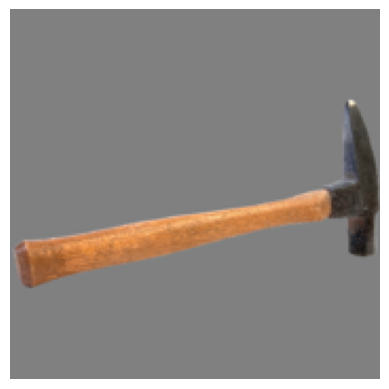

In [10]:
plt.imshow(images[0,0])
plt.grid(None)
plt.axis('off');

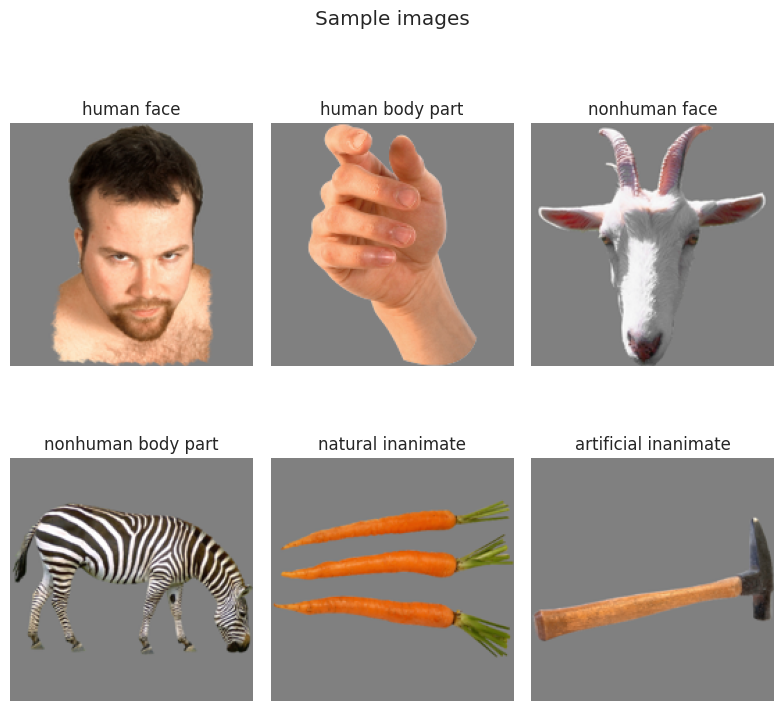

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8,8))

counter = 0
image_ids = [cat3_ids[0], cat2_ids[0], cat6_ids[0], cat5_ids[0], cat4_ids[0], cat1_ids[0]]
for ax in axes.flat:
  im = ax.imshow(images[image_ids[counter], 0])
  ax.set_title(ordered_categories[counter])
  ax.grid(None)
  ax.axis('off')
  counter += 1

fig.suptitle('Sample images')
plt.tight_layout()
plt.savefig('sample_images.png')
plt.show()

## 1.2: Save images

In [12]:
np.save('images.npy', ordered_images)
np.save('image_labels.npy', ordered_labels)

# 2: Example.

As an example, I will generate RSM and RDMs for the first patient in the study.

## 2.1: Load in and adjust the data.

In [ ]:
# Load the data for one subject
subj_initials = 'BE'
data_pack = load_data_for_a_subj(subj_initials)
images, roi_data, roi_names, n_rois, categories, n_categories, labels, label_dict = data_pack
n_stimuli = len(images)

In [ ]:
# adjust image ordering
current_ordering = []

for i in range(92):
  for j in range(96):
    if np.array_equal(ordered_images[i, 0], images[j, 0]):
      current_ordering.append(j)
  
current_ids = np.asarray(current_ordering)

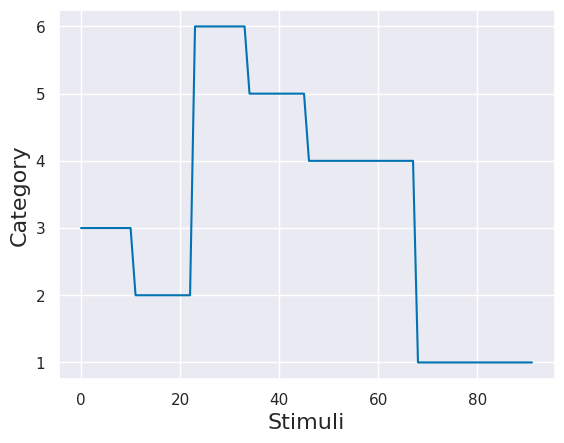

In [ ]:
plt.plot(labels[current_ids])
plt.xlabel('Stimuli', fontsize=16)
plt.ylabel('Category', fontsize=16)
plt.show()

## 2.2: Generate the RSM.

(0.0, 92.0)

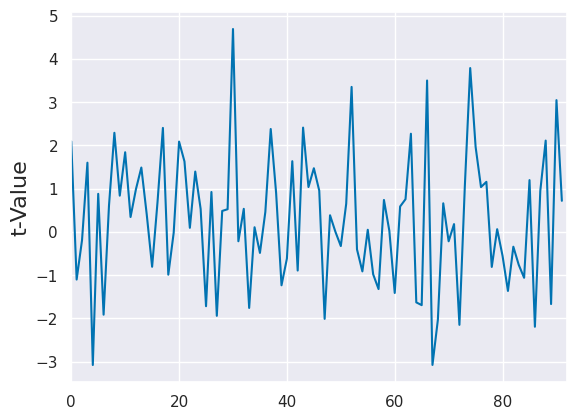

In [ ]:
# choose ROI index
roi_id = 0

sorted_roi_data = roi_data[roi_id][current_ids, :]
plt.plot(sorted_roi_data[:,0])
plt.ylabel('t-Value', fontsize=16)
plt.xlim(0, 92)

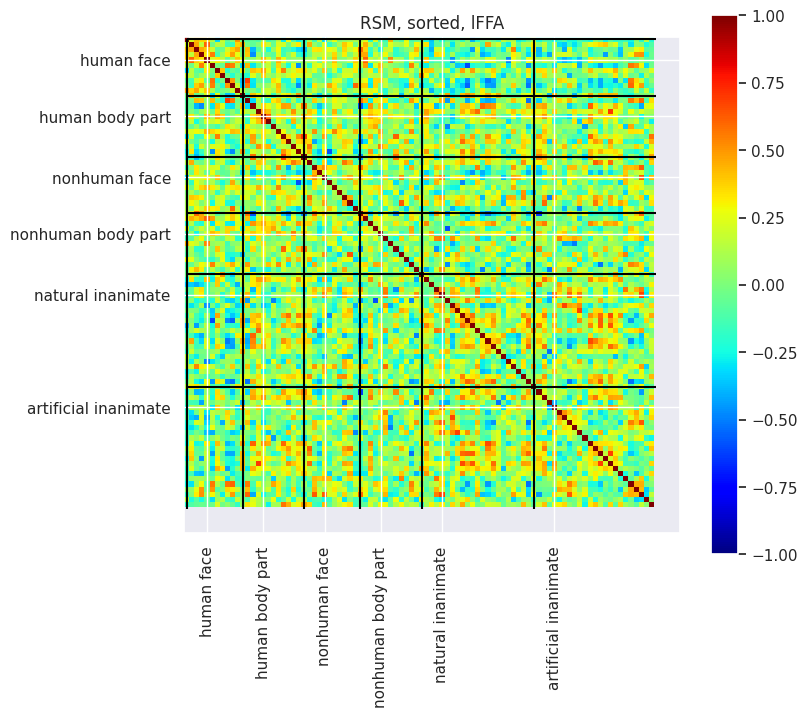

In [ ]:
# generate RSM
# Plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))

rsm = np.corrcoef(sorted_roi_data)

plt.imshow(
    rsm, 
    cmap='jet', 
    vmin=-1,
    vmax=1,
)
plt.colorbar()

binsize = [len(cat3_ids), len(cat2_ids), len(cat6_ids), len(cat5_ids), len(cat4_ids), len(cat1_ids)]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+4))
ax.set_xticklabels(ordered_categories, rotation = 90)
ax.set_yticks(list(np.array(edges)+4))
ax.set_yticklabels(ordered_categories)
ax.vlines(edges,0,92, color='black')
ax.hlines(edges,0,92, color='black')
ax.set_title('RSM, sorted, %s' % roi_names[roi_id])
plt.show()

## 2.3: Generate RDMs

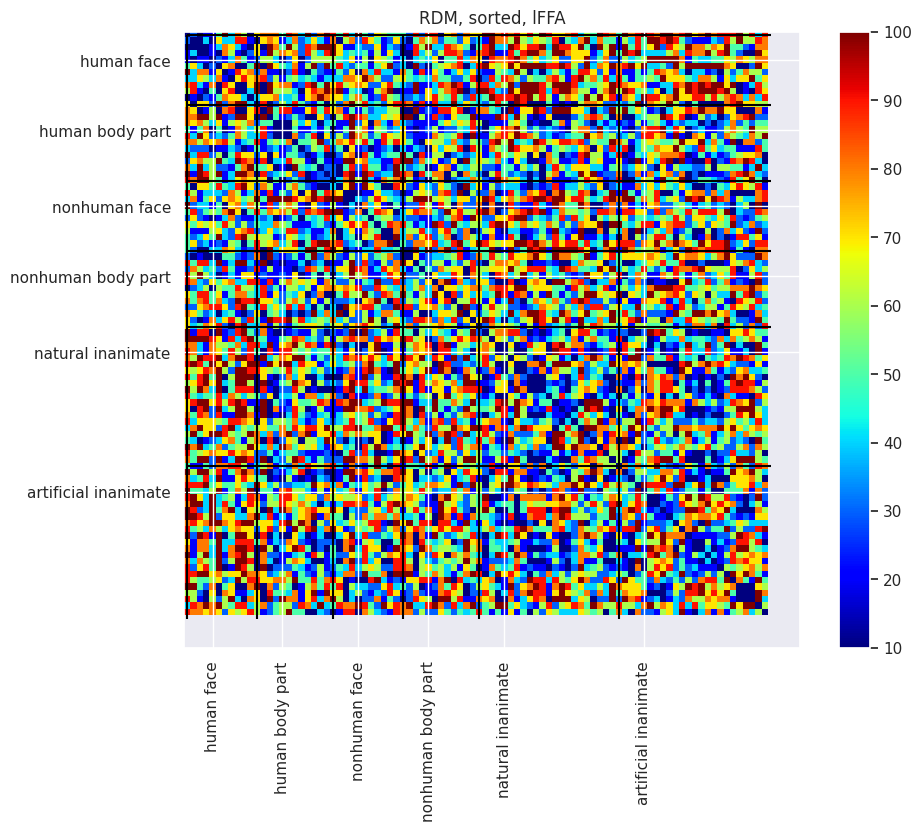

In [ ]:
# plot 
f, ax = plt.subplots(1,1, figsize=(10, 8))

rdm = digitize_rdm(1-rsm, n_bins=10)

plt.imshow(
    rdm, 
    cmap='jet', 
)
plt.colorbar()

binsize = [len(cat3_ids), len(cat2_ids), len(cat6_ids), len(cat5_ids), len(cat4_ids), len(cat1_ids)]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+4))
ax.set_xticklabels(ordered_categories, rotation = 90)
ax.set_yticks(list(np.array(edges)+4))
ax.set_yticklabels(ordered_categories)
ax.vlines(edges,0,92, color='black')
ax.hlines(edges,0,92, color='black')
ax.set_title('RDM, sorted, %s' % roi_names[roi_id])
plt.show()

# 3: Build relevant functions for constructing RSMs and RDMs.

## 3.1: Functions to generate matrices

In [13]:
# Function to generate a single RSM and RDM given the specific subject, ROI, and images (in order)
def generate_matrices(subj, roi_num, ord_images):

  # load data
  data_pack = load_data_for_a_subj(subj_initials)
  images, roi_data, roi_names, n_rois, categories, n_categories, labels, label_dict = data_pack
  
  # adjust ordering
  current_ordering = []

  for i in range(N_IMAGES):
    for j in range(N_TOT_IMAGES):
      if np.array_equal(ord_images[i,0], images[j,0]):
        current_ordering.append(j)

  current_ids = np.asarray(current_ordering)
  sorted_roi_data = roi_data[roi_num][current_ids, :]

  # generate RSM
  rsm = np.corrcoef(sorted_roi_data)

  # generate RDM
  rdm = digitize_rdm(1-rsm, n_bins=10)

  return rsm, rdm

In [14]:
# Function to generate all RSMs and RDms for all ROIs for a subject
def generate_all(subj, ord_images):
  # outputs
  rsms = []
  rdms = []

  for i in range(N_ROIS):
    cur_rsm, cur_rdm = generate_matrices(subj, i, ord_images)
    rsms.append(cur_rsm)
    rdms.append(cur_rdm)
  
  return np.asarray(rsms), np.asarray(rdms)

## 3.2: Plotting functions

In [15]:
# Plot a single RSM
def plot_rsm(rsm, title='', save=False, save_name='rsm.png'):
  
  # plot
  fig, ax = plt.subplots(1, 1, figsize=(8,7))

  plt.imshow(rsm, cmap='jet', vmin=-1, vmax=1)
  plt.colorbar()

  binsize = [len(cat3_ids), len(cat2_ids), len(cat6_ids), len(cat5_ids), len(cat4_ids), len(cat1_ids)]
  edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
  ax.set_xticks(list(np.array(edges)+4))
  ax.set_xticklabels(ordered_categories, rotation = 90)
  ax.set_yticks(list(np.array(edges)+4))
  ax.set_yticklabels(ordered_categories)
  ax.vlines(edges,0,92, color='black')
  ax.hlines(edges,0,92, color='black')
  ax.set_title(title)
  
  # save
  if save:
    plt.savefig(save_name, dpi=300, bbox_inches='tight')

  plt.show()
  return

In [16]:
# Plot a single RDM
def plot_rdm(rdm, title='', save=False, save_name='rsm.png'):
  
  # plot
  fig, ax = plt.subplots(1, 1, figsize=(8,7))

  plt.imshow(rdm, cmap='jet', vmin=0, vmax=100)
  plt.colorbar()

  binsize = [len(cat3_ids), len(cat2_ids), len(cat6_ids), len(cat5_ids), len(cat4_ids), len(cat1_ids)]
  edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
  ax.set_xticks(list(np.array(edges)+4))
  ax.set_xticklabels(ordered_categories, rotation = 90)
  ax.set_yticks(list(np.array(edges)+4))
  ax.set_yticklabels(ordered_categories)
  ax.vlines(edges,0,92, color='black')
  ax.hlines(edges,0,92, color='black')
  ax.set_title(title)
  
  # save
  if save:
    plt.savefig(save_name, dpi=300, bbox_inches='tight')

  plt.show()
  return

In [17]:
# Plot all RSMs for a given subject (with all four)
def show_rsms(matrices, title='', save=False, save_name=''):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,7))
  binsize = [len(cat3_ids), len(cat2_ids), len(cat6_ids), len(cat5_ids), len(cat4_ids), len(cat1_ids)]
  edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]

  cur_roi = 0
  for ax in axes.flat:
      im = ax.imshow(matrices[cur_roi], vmin=-1, vmax=1, cmap='jet')
      
      ax.set_title(roi_names[cur_roi])
      if cur_roi == 0:
        ax.set_yticks(list(np.array(edges)+4))
        ax.set_yticklabels(ordered_categories)  
      elif cur_roi == 2:
        ax.set_xticks(list(np.array(edges)+4))
        ax.set_xticklabels(ordered_categories, rotation = 90)
        ax.set_yticks(list(np.array(edges)+4))
        ax.set_yticklabels(ordered_categories)    
      elif cur_roi == 3:
        ax.set_xticks(list(np.array(edges)+4))
        ax.set_xticklabels(ordered_categories, rotation = 90)
      ax.vlines(edges,0,92, color='black')
      ax.hlines(edges,0,92, color='black')
      cur_roi += 1

  fig.colorbar(im, ax=axes.ravel().tolist())

  fig.suptitle(title)
  if save:
    plt.savefig(save_name, dpi=300, bbox_inches='tight')
  
  plt.show()
  return

In [18]:
# Plot all RDMs for a given subject (with all four ROIs)
def show_rdms(matrices, title='', save=False, save_name=''):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,7))
  binsize = [len(cat3_ids), len(cat2_ids), len(cat6_ids), len(cat5_ids), len(cat4_ids), len(cat1_ids)]
  edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]

  cur_roi = 0
  for ax in axes.flat:
      im = ax.imshow(matrices[cur_roi], cmap='jet')
      ax.set_title(roi_names[cur_roi])
      if cur_roi == 0:
        ax.set_yticks(list(np.array(edges)+4))
        ax.set_yticklabels(ordered_categories)  
      elif cur_roi == 2:
        ax.set_xticks(list(np.array(edges)+4))
        ax.set_xticklabels(ordered_categories, rotation = 90)
        ax.set_yticks(list(np.array(edges)+4))
        ax.set_yticklabels(ordered_categories)    
      elif cur_roi == 3:
        ax.set_xticks(list(np.array(edges)+4))
        ax.set_xticklabels(ordered_categories, rotation = 90)
      ax.vlines(edges,0,92, color='black')
      ax.hlines(edges,0,92, color='black')
      cur_roi += 1

  fig.colorbar(im, ax=axes.ravel().tolist())

  fig.suptitle(title)

  if save:
    plt.savefig(save_name, dpi=300, bbox_inches='tight')
  
  plt.show()
  return

# 4: Generate all RSMs and RDMs for human data.

In [ ]:
# generate all the data
BE_rsms, BE_rdms = generate_all('BE', ordered_images)
KO_rsms, KO_rdms = generate_all('KO', ordered_images)
SN_rsms, SN_rdms = generate_all('SN', ordered_images)
TI_rsms, TI_rdms = generate_all('TI', ordered_images)

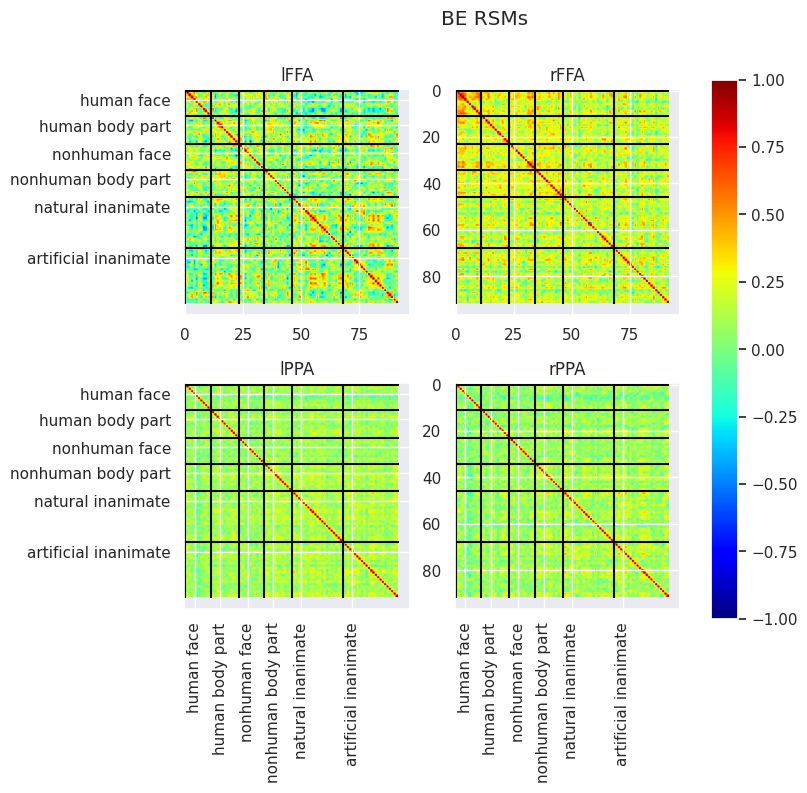

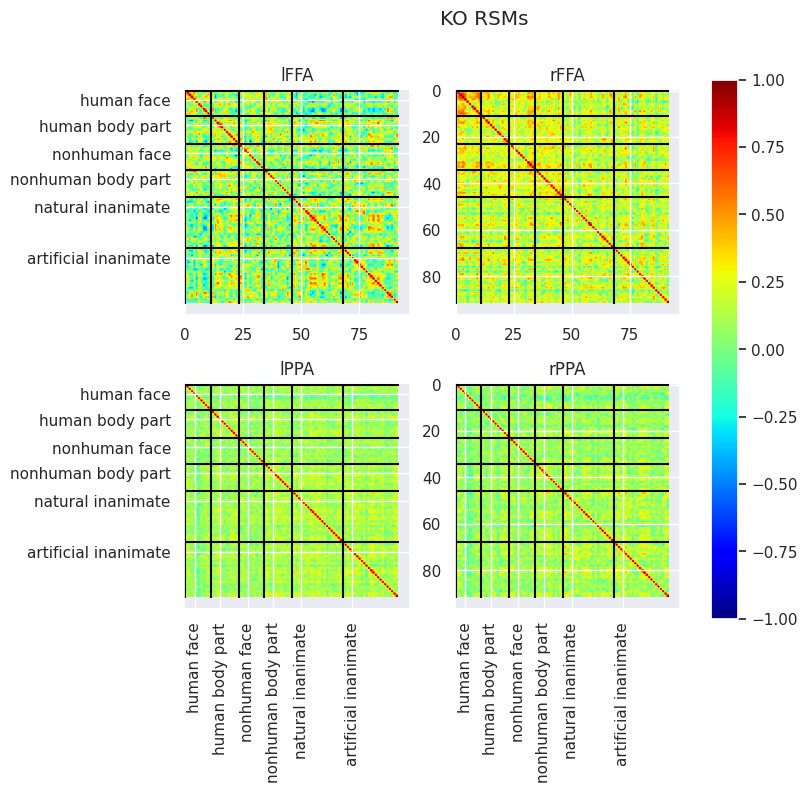

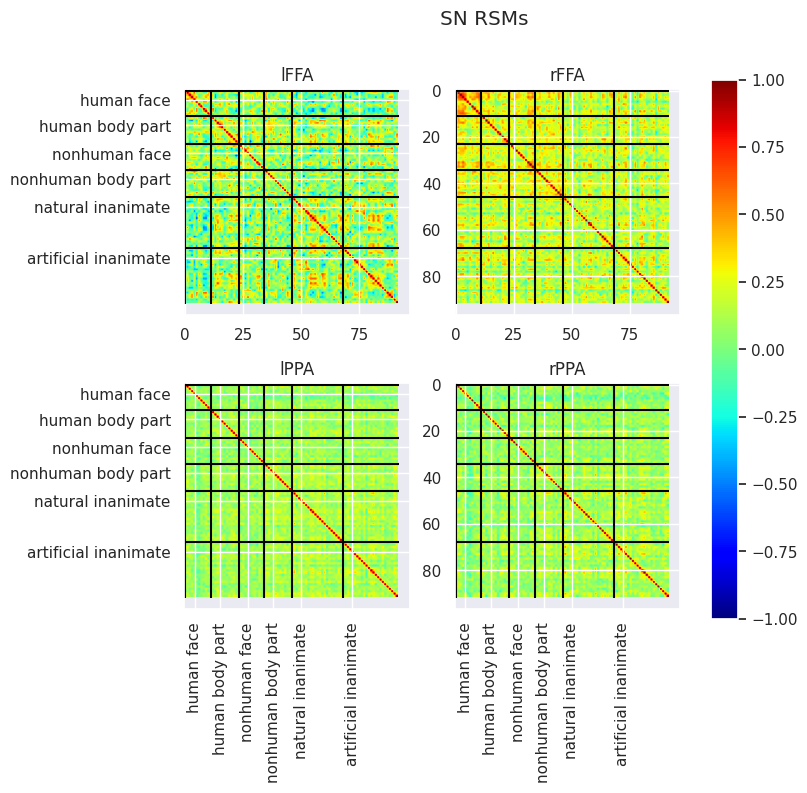

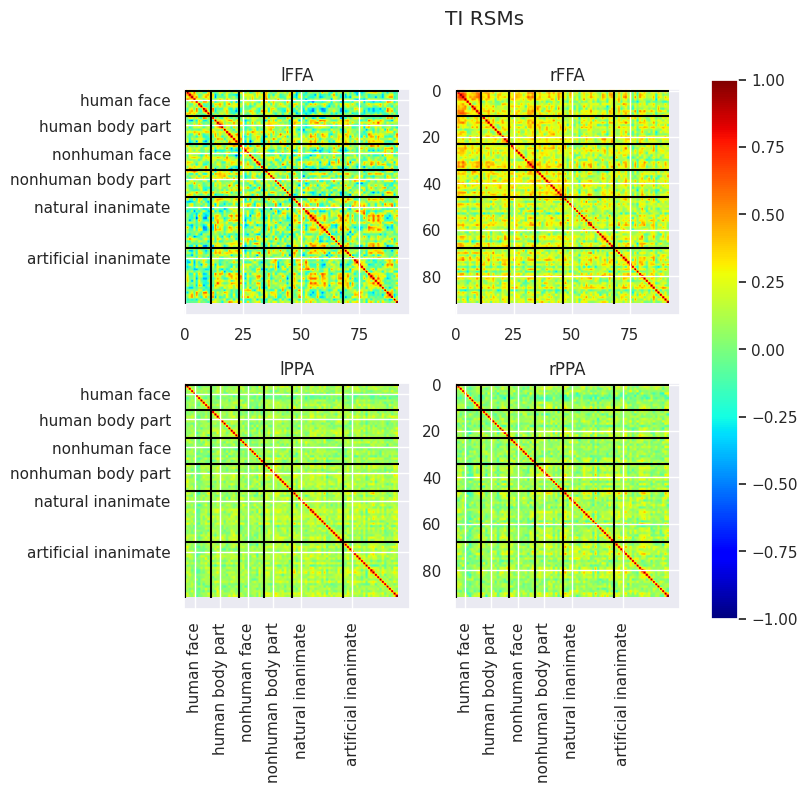

In [ ]:
# show and save all the RSMs
show_rsms(BE_rsms, title='BE RSMs', save=True, save_name='be_rsms.png')
show_rsms(KO_rsms, title='KO RSMs', save=True, save_name='ko_rsms.png')
show_rsms(SN_rsms, title='SN RSMs', save=True, save_name='sn_rsms.png')
show_rsms(TI_rsms, title='TI RSMs', save=True, save_name='ti_rsms.png')

In [ ]:
# show and save all the RDMs
show_rdms(BE_rdms, title='BE RDMs', save=True, save_name='be_rdms.png')
show_rdms(KO_rdms, title='KO RDMs', save=True, save_name='ko_rdms.png')
show_rdms(SN_rdms, title='SN RDMs', save=True, save_name='sn_rdms.png')
show_rdms(TI_rdms, title='TI RDMs', save=True, save_name='ti_rdms.png')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
all_rsms = np.asarray([BE_rsms, KO_rsms, SN_rsms, TI_rsms])
all_rdms = np.asarray([BE_rdms, KO_rdms, SN_rdms, TI_rdms])

In [ ]:
np.save('human_data.npy', np.asarray([all_rsms, all_rdms]))

# 5: Generating RDMs for permutation tests.

## 5.1: Load in the data and generate relevant functions

In [19]:
# LOAD IN ALL OF THE ROI DATA
be_images, be_roi_data, _, _, _, _, _, _ = load_data_for_a_subj('BE')
ko_images, ko_roi_data, _, _, _, _, _, _ = load_data_for_a_subj('KO')
sn_images, sn_roi_data, _, _, _, _, _, _ = load_data_for_a_subj('SN')
ti_images, ti_roi_data, _, _, _, _, _, _ = load_data_for_a_subj('TI')

In [20]:
def generate_matrices_preloaded(roi_data, roi_num, ord_images, raw_images):
  # adjust ordering
  current_ordering = []

  for i in range(N_IMAGES):
    for j in range(N_TOT_IMAGES):
      if np.array_equal(ord_images[i,0], raw_images[j,0]):
        current_ordering.append(j)

  current_ids = np.asarray(current_ordering)
  sorted_roi_data = roi_data[roi_num][current_ids, :]

  # generate RSM
  rsm = np.corrcoef(sorted_roi_data)

  # generate RDM
  rdm = digitize_rdm(1-rsm, n_bins=10)

  return rsm, rdm

In [21]:
# function to generate RDMs for permutation test 
def generate_permuted_rdms(roi_num, B=10000):

  # list to return
  permuted_rdms = []
  
  # load in all data
  all_roi_data = [be_roi_data, ko_roi_data, sn_roi_data, ti_roi_data]
  all_image_data = [be_images, ko_images, sn_images, ti_images]
  
  for i in range(B):

    # randomly choose subject
    cur_subj = np.random.choice(np.arange(0,4))
    cur_roi_data = all_roi_data[cur_subj]
    cur_images = all_image_data[cur_subj]

    # generate permutation of images
    p = np.random.permutation(n_images)
    permuted_images = ordered_images[p]

    # generate RSM and RDM
    _, cur_rdm = generate_matrices_preloaded(cur_roi_data, roi_num, permuted_images, cur_images)

    permuted_rdms.append(cur_rdm)
  
  return permuted_rdms

## 5.2: Apply functions to the data

In [22]:
# generate rdms
roi0_permuted_rdms = generate_permuted_rdms(0)
roi1_permuted_rdms = generate_permuted_rdms(1)
roi2_permuted_rdms = generate_permuted_rdms(2)
roi3_permuted_rdms = generate_permuted_rdms(3)

In [24]:
# save permuted rdms
np.save('human_permuted.npy', np.asarray([roi0_permuted_rdms,
                                          roi1_permuted_rdms,
                                          roi2_permuted_rdms,
                                          roi3_permuted_rdms]))

In [27]:
np.savez_compressed('human_permuted',
                    lffa=roi0_permuted_rdms,
                    rffa=roi1_permuted_rdms,
                    lppa=roi2_permuted_rdms,
                    rppa=roi3_permuted_rdms)

# 6: Comparing RDMS

Utilizing Spearman correlation as the similarity metric

In [ ]:
from scipy.stats import spearmanr
n_subj = 4

## 6.1: Same ROI, different individuals

In [ ]:
subj_inits = ['BE', 'KO', 'SN', 'TI']

In [ ]:
print("Similarity between individuals for the same ROI:")
# i = ROI
for i in range(n_rois):
  # j = individual 1
  for j in range(n_subj):
    # k = individual 2
    for k in range(n_subj):
      if j < k:
        rdm1 = all_rsms[j, i]
        rdm2 = all_rsms[k, i]
        res = spearmanr(rdm1, rdm2, axis=None)
        print(f'{roi_names[i]}: {subj_inits[j]}, {subj_inits[k]}: {res.statistic: .3f}')

Similarity between individuals for the same ROI:
lFFA: BE, KO:  0.069
lFFA: BE, SN:  0.046
lFFA: BE, TI:  0.073
lFFA: KO, SN:  0.190
lFFA: KO, TI:  0.098
lFFA: SN, TI:  0.159
rFFA: BE, KO:  0.128
rFFA: BE, SN:  0.133
rFFA: BE, TI:  0.105
rFFA: KO, SN:  0.127
rFFA: KO, TI:  0.207
rFFA: SN, TI:  0.123
lPPA: BE, KO:  0.079
lPPA: BE, SN:  0.099
lPPA: BE, TI:  0.111
lPPA: KO, SN:  0.100
lPPA: KO, TI:  0.066
lPPA: SN, TI:  0.267
rPPA: BE, KO:  0.046
rPPA: BE, SN:  0.042
rPPA: BE, TI:  0.190
rPPA: KO, SN:  0.060
rPPA: KO, TI:  0.067
rPPA: SN, TI:  0.148


In [ ]:
print("Similarity within individuals for different ROIs:")
# i = individual
for i in range(n_subj):
  # j = ROI 1
  for j in range(n_rois):
    # k = ROI 2
    for k in range(n_rois):
      if j < k:
        rdm1 = all_rsms[i, j]
        rdm2 = all_rsms[i, k]
        res = spearmanr(rdm1, rdm2, axis=None)
        print(f'{subj_inits[i]}: {roi_names[j]}, {roi_names[k]}: {res.statistic: .3f}')

Similarity within individuals for different ROIs:
BE: lFFA, rFFA:  0.093
BE: lFFA, lPPA:  0.179
BE: lFFA, rPPA:  0.133
BE: rFFA, lPPA:  0.209
BE: rFFA, rPPA:  0.178
BE: lPPA, rPPA:  0.419
KO: lFFA, rFFA:  0.641
KO: lFFA, lPPA:  0.314
KO: lFFA, rPPA:  0.142
KO: rFFA, lPPA:  0.312
KO: rFFA, rPPA:  0.158
KO: lPPA, rPPA:  0.248
SN: lFFA, rFFA:  0.256
SN: lFFA, lPPA:  0.210
SN: lFFA, rPPA:  0.108
SN: rFFA, lPPA:  0.263
SN: rFFA, rPPA:  0.223
SN: lPPA, rPPA:  0.276
TI: lFFA, rFFA:  0.486
TI: lFFA, lPPA:  0.166
TI: lFFA, rPPA:  0.189
TI: rFFA, lPPA:  0.208
TI: rFFA, rPPA:  0.287
TI: lPPA, rPPA:  0.455


# 7: Stuff from Tutorial

Similarity metric: Pearson correlation

Compute the similarity between each of the neural responses. We can compute this for each ROI. We build a 92x92 matrix since the last four images don't have labels.

Text(0, 0.5, 'stimuli id')

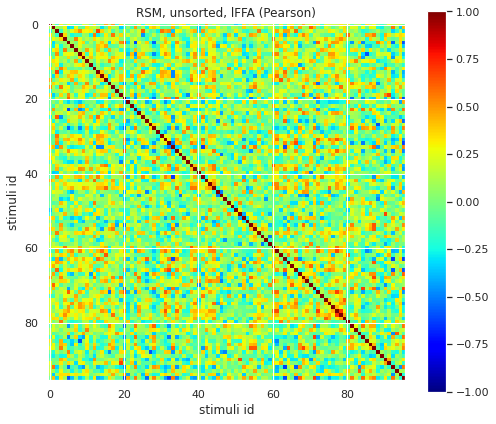

In [ ]:
# Choose your ROI here!
roi_id = 0 

# Plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))

plt.imshow(
    np.corrcoef(roi_data[roi_id]), 
    cmap='jet', 
    vmin=-1,
    vmax=1,
)
plt.colorbar()
ax.set_title('RSM, unsorted, %s (Pearson)' % (roi_names[roi_id])) 
ax.set_xlabel('stimuli id')
ax.set_ylabel('stimuli id')

In [ ]:
roi_data[roi_id].shape

(96, 34)

Text(0, 0.5, 'stimuli id')

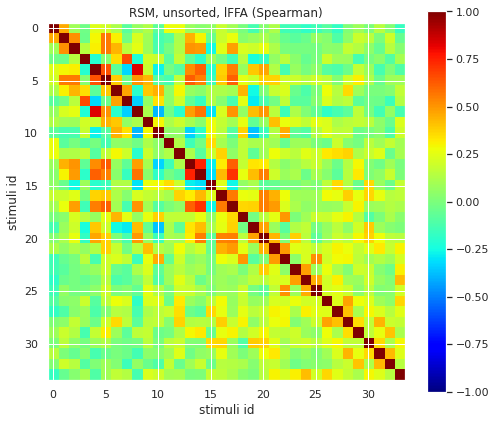

In [ ]:
# RSM with spearman correlation instead
from scipy.stats import spearmanr

# Plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))

rank_srm, _ = spearmanr(roi_data[roi_id])

plt.imshow(
    rank_srm,
    cmap='jet',
    vmin=-1,
    vmax=1
)
plt.colorbar()
ax.set_title('RSM, unsorted, %s (Spearman)' % (roi_names[roi_id])) 
ax.set_xlabel('stimuli id')
ax.set_ylabel('stimuli id')

In [ ]:
rank_srm.shape

(34, 34)

`rank_srm` is 34 x 34 because 34 is the number of voxels. Need to explore the differences between Pearson and Spearman more